In [1]:
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt

from mapie.regression import MapieRegressor
from mapie.metrics import regression_coverage_score, regression_mean_width_score
from mapie.regression import MapieRegressor
from mapie.subsample import Subsample

from sklearn.preprocessing import  MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

In [2]:
path = 'data/data.csv'
data = pd.read_csv(path)
normalized_pctg_change = data['normalized_percent_change'] # Save variable fot later use in model
data.drop(columns=['normalized_percent_change'], inplace=True)

In [3]:
# Proportion of zeros in the database
normalized_pctg_change[normalized_pctg_change == 0.00].count()/normalized_pctg_change.count()

0.7488943488943489

In [4]:
xgboost_df = data.copy()
# One-hot encoding
demographic_vars = ['gender_source_value', 'race_source_value', 'ethnicity_source_value']
xgboost_df = pd.get_dummies(xgboost_df, columns=demographic_vars)
# Scaling: Apparently there's no difference if a use a StandardScaler vs MinMaxScaler
scaler = MinMaxScaler()
numeric_vars = ['mean_led_per_visit', 'age', 'length_of_stay', 'days_since_last_visit', 'days_to_diagnosis']
for i in range(len(numeric_vars)):
    xgboost_df[numeric_vars[i]] = scaler.fit_transform(xgboost_df[[numeric_vars[i]]])

# Reordering the columns so that the target variable is the last one
prediction_to_last = xgboost_df.pop('prediction')
xgboost_df['prediction'] = prediction_to_last

# Defining the features and target variable
X = xgboost_df.iloc[:, :-1] # Shape is rows x features (38)
y = xgboost_df.iloc[:, -1]

# Split data into training and testing sets
# I don't need to use cupy or cudf to send the data to the GPU because I'm using DMatrix
random_state = 21
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
d_train = xgb.DMatrix(X_train, y_train, label=y_train)
d_test = xgb.DMatrix(X_test, y_test, label=y_test)
best_params = {
    # Classification
    "eval_metric": "auc", # Area under the curve
    "objective": "binary:logistic", # Logistic regression for binary classification, output probability
    'sampling_method': 'gradient_based', # The selection probability for each training instance is proportional to the regularized absolute value of gradients 
    'alpha': 0.1, # L1 regularization
    'lambda': 1, # L2 regularization
    'learning_rate': 0.1, 
    'max_depth': 7,
    'tree_method': 'hist', 
    'device': "cuda",
}
num_boost_round = 700
regression_params_short = {'alpha': 0.1, 'lambda': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 700, "eval_metric": 'rmse', 'objective': 'reg:squarederror', 'sampling_method': 'gradient_based', 'tree_method': 'hist', 'device': "cuda"} # Updated 28/08/2024. Range (0,1)
regression_params_long = {'alpha': 1, 'lambda': 0.1, 'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 700, "eval_metric": 'rmse', 'objective': 'reg:squarederror', 'sampling_method': 'gradient_based', 'tree_method': 'hist', 'device': "cuda"} # Updated 01/09/2024. Range (-1,1) Decreases coverage in Jackknife+ by 0.02
binary_params = {'alpha': 0, 'lambda': 0.1, 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 800, "eval_metric": 'auc', 'objective': 'binary:logistic', 'sampling_method': 'gradient_based', 'tree_method': 'hist', 'device': "cuda",} 

d_all = xgb.DMatrix(X)
model = xgb.train(best_params, d_train, num_boost_round=num_boost_round, evals=((d_test, "test"),),verbose_eval=False, early_stopping_rounds=10)
y_pred_proba_all = model.predict(d_all, iteration_range=(0, model.best_iteration + 1))
y_pred_all = (y_pred_proba_all > 0.5).astype(int)

In [5]:
def split_into_five_equal_parts(X, y_binary, y_continuous, random_state=42):
    """
    Split data into 5 equal parts, maintaining alignment between binary and continuous outcomes
    
    Parameters:
    -----------
    X : features DataFrame
    y_binary : binary outcome (change/no change in LEDD)
    y_continuous : continuous outcome (normalized percentage change)
    random_state : for reproducibility
    
    Returns:
    --------
    Training, calibration, and test sets for both binary and continuous outcomes
    """
    # First split: 20% for test set, 80% remaining -> Test
    X_temp, X_test, y_binary_temp, y_binary_test, y_cont_temp, y_cont_test = train_test_split(
        X, y_binary, y_continuous, test_size=0.2, random_state=random_state
    )
    
    # Splits 75% of the 80%, which leaves one set with 20% and another with 60% -> Train
    X_train, X_temp2, y_binary_train, y_binary_temp2, y_cont_train, y_cont_temp2 = train_test_split(
        X_temp, y_binary_temp, y_cont_temp, test_size=0.75, random_state=random_state
    )
    
    # Splits 66% of the 60%, which leaves one set with 20% and another with 40% -> Calib1
    X_calib1, X_temp3, y_binary_calib1, y_binary_temp3, y_cont_calib1, y_cont_temp3 = train_test_split(
        X_temp2, y_binary_temp2, y_cont_temp2, test_size=0.5, random_state=random_state
    )

    # Splits 50% of the 40%, which leaves two sets with 20% each -> Calib2 and Calib3
    X_calib2, X_calib3, y_binary_calib2, y_binary_calib3, y_cont_calib2, y_cont_calib3 = train_test_split(
        X_temp3, y_binary_temp3, y_cont_temp3, test_size=0.5, random_state=random_state
    )
    
    return (
        X_train, X_calib1, X_calib2, X_calib3, X_test,
        y_binary_train, y_binary_calib1, y_binary_calib2, y_binary_calib3, y_binary_test,
        y_cont_train, y_cont_calib1, y_cont_calib2, y_cont_calib3, y_cont_test
    )

In [24]:
def conformal_prediction_zero_inflated(X, y_binary, y_continuous, alpha_tilda=0.9):
    # Split data into five parts
    (X_train, X_calib1, X_calib2, X_calib3, X_test, 
     y_binary_train, y_binary_calib1, y_binary_calib2, y_binary_calib3, y_binary_test,
     y_cont_train, y_cont_calib1, y_cont_calib2, y_cont_calib3, y_cont_test) = split_into_five_equal_parts(X, y_binary, y_continuous)
    
    # Train classification model on binary outcome
    classifier = xgb.XGBClassifier(**binary_params)
    # Fit classifier with binary outcome (change/no change in LEDD)
    classifier.fit(X_train, y_binary_train)
    # Get predicted probabilities for class one[:,] (change in LEDD) from the first calibration set
    # These probabilities will be used to calculate alpha_r
    probs_calib1 = classifier.predict_proba(X_calib1)[:, 1]
    
    # Train regression model on non-zero continuous outcomes
    # Use mask to filter out patients with no change in LEDD or whose predicted probabily of change is minimal
    mask_nonzero = y_binary_train == 1
    regressor = xgb.XGBRegressor(**regression_params_short)
    # Fit regressor with continuous outcome (normalized percentage change)
    regressor.fit(X_train[mask_nonzero], y_cont_train[mask_nonzero])
    
    
    # print(f'First calibration dataset{probs_calib1, probs_calib1}')
    # Try different values of r to optimize intervals
    r_values = [0.5, 0.6]
    all_interval_lengths = []
    
    # Report
    # X amount of data is below alpha_r
    for r in r_values:
        # Find quantiles for predicted probabilities
        alpha_r = np.quantile(probs_calib1, r)
        # print(f'alpha_r: {alpha_r}')

        # Second calibration set: Calculate beta_hat and accuracy of zero predictions
        probs_calib2 = classifier.predict_proba(X_calib2)[:, 1] # Predicted probabilities for the secnd calibration set
        pred_zeros = probs_calib2 <= alpha_r # Predicted probabilities less than or equal to alpha_r
        beta_hat = np.mean(y_binary_calib2[pred_zeros] == 0) # Accuracy of zero predictions (propotion of correct zero predictions) proportion of true zeros among predicted zerps
        # print(f'beta_hat: {beta_hat}')
        # Calculate final quantile for interval width
        # beta_hat * r coverage ww aleady achieved. 1-r is a fraction of the nonzero data
        if np.isnan(beta_hat):
            continue

        if beta_hat < alpha_tilda:
            # If classification performance is poor, use VCI
            y_pred_calib3 = regressor.predict(X_calib3)
            residuals = np.abs(y_cont_calib3 - y_pred_calib3)
            interval_width = np.quantile(residuals, alpha_tilda)
            all_interval_lengths.append((r, interval_width, alpha_r, False))  # False flag for VCI
        else:     
            final_quantile = (alpha_tilda - beta_hat * r) / (1 - r)
            if final_quantile < 0:
                    final_quantile = alpha_tilda
            if final_quantile > 1:
                continue
            
            # A: Prob of true value being zero
            # B: Model predict this point as zero
            # Third calibration set: Calculate interval width
            probs_calib3 = classifier.predict_proba(X_calib3)[:, 1]
            nonzero_mask = probs_calib3 > alpha_r
            if not any(nonzero_mask):
                continue
            
            y_pred_nonzero = regressor.predict(X_calib3[nonzero_mask])
            residuals = np.abs(y_cont_calib3[nonzero_mask] - y_pred_nonzero) # True vs Predicted
            interval_width = np.quantile(residuals, final_quantile) #* (1 - r) # We choose the quantile of the predicted residuals
            all_interval_lengths.append((r, interval_width, alpha_r, True)) # Average int_width = interval_width*(1 - r)
            # Calibration set 2 for the r
            nonzero_coverage = np.mean((y_test[nonzero_mask] >= lower_bound[nonzero_mask]) & 
                                     (y_test[nonzero_mask] <= upper_bound[nonzero_mask]))
            nonzero_width = np.mean(upper_bound[nonzero_mask] - lower_bound[nonzero_mask])

        # Optimal r only uses calibration 2. FIrst part of cal r, other for b hat, threshold and quantile. And then the interval length
        # I need to modify the approach in my current code. Now calibration 2 will be futher divided into 2 parts. The first part will be used to find the optimal r. The second part will be used for b_hat, threshold and quantile.
        #      r now will have nothing to do with the third calibration set because it is violating the principle of exchangaebility.
    if not all_interval_lengths:
        raise ValueError("No valid intervals found")
    
    # Choose best r value and corresponding width
    best_r, best_width, best_alpha_r, is_cpci = min(all_interval_lengths, key=lambda x: x[1])
    # Get beta_hat for best r
    probs_calib2 = classifier.predict_proba(X_calib2)[:, 1]
    pred_zeros = probs_calib2 <= best_alpha_r
    best_beta_hat = np.mean(y_binary_calib2[pred_zeros] == 0)

    # Make predictions on test set
    test_pred = regressor.predict(X_test)

    if is_cpci:
        # Use CPCI Approach
            test_probs = classifier.predict_proba(X_test)[:, 1]
            nonzero_mask = test_probs > best_alpha_r
                # Create prediction intervals
            lower_bound = np.zeros_like(test_pred)
            upper_bound = np.zeros_like(test_pred)
    
            lower_bound[nonzero_mask] = test_pred[nonzero_mask] - best_width
            upper_bound[nonzero_mask] = test_pred[nonzero_mask] + best_width
    else:
        # Use VCI Approach
        lower_bound = test_pred - best_width
        upper_bound = test_pred + best_width
    
    return lower_bound, upper_bound, y_cont_test

In [52]:
def conformal_prediction_zero_inflated_v2(X, y_binary, y_continuous, alpha_tilda=0.9):
    # Split data into five parts first
    (X_train, X_calib1, X_calib2, X_calib3, X_test, 
     y_binary_train, y_binary_calib1, y_binary_calib2, y_binary_calib3, y_binary_test,
     y_cont_train, y_cont_calib1, y_cont_calib2, y_cont_calib3, y_cont_test) = split_into_five_equal_parts(
         X, y_binary, y_continuous)
    
    # Train classification model
    classifier = xgb.XGBClassifier(**binary_params)
    classifier.fit(X_train, y_binary_train)
    
    # Train regression model on non-zero continuous outcomes
    mask_nonzero = y_binary_train == 1
    regressor = xgb.XGBRegressor(**regression_params_short)
    regressor.fit(X_train[mask_nonzero], y_cont_train[mask_nonzero])
    
    # Get probabilities for first calibration set
    probs_calib1 = classifier.predict_proba(X_calib1)[:, 1]
    
    # Split calibration set 2 for r optimization and beta estimation
    split_index = len(X_calib2) // 2
    X_calib2_r = X_calib2[:split_index]
    X_calib2_beta = X_calib2[split_index:]
    y_binary_calib2_r = y_binary_calib2[:split_index]
    y_binary_calib2_beta = y_binary_calib2[split_index:]
    y_cont_calib2_r = y_cont_calib2[:split_index]
    y_cont_calib2_beta = y_cont_calib2[split_index:]
    
    # Find optimal r using first part of calib2
    r_values = np.arange(0.1, 0.95, 0.05)
    all_interval_lengths = []
    
    # Use calib1 for alpha_r and first part of calib2 for optimization
    for r in r_values:
        alpha_r = np.quantile(probs_calib1, r)
        
        # Use first part of calib2 for optimization
        probs_calib2_r = classifier.predict_proba(X_calib2_r)[:, 1]
        pred_zeros_r = probs_calib2_r <= alpha_r
        nonzero_mask_r = probs_calib2_r > alpha_r
        
        if not any(nonzero_mask_r):
            continue
            
        y_pred_nonzero = regressor.predict(X_calib2_r[nonzero_mask_r])
        residuals = np.abs(y_cont_calib2_r[nonzero_mask_r] - y_pred_nonzero)
        width = np.mean(residuals)
        all_interval_lengths.append((r, width, alpha_r))
    
    if not all_interval_lengths:
        raise ValueError("No valid intervals found")
    
    # Get best r
    best_r, best_width, best_alpha_r = min(all_interval_lengths, key=lambda x: x[1])
    
    # Now use second part of calib2 for beta_hat and threshold
    alpha_r = np.quantile(probs_calib1, best_r)  # Recalculate alpha_r with best_r
    probs_calib2_beta = classifier.predict_proba(X_calib2_beta)[:, 1]
    pred_zeros_beta = probs_calib2_beta <= alpha_r
    beta_hat = np.mean(y_binary_calib2_beta[pred_zeros_beta] == 0)
    
    if beta_hat < alpha_tilda:
        # If classification performance is poor, use VCI
        y_pred_calib3 = regressor.predict(X_calib3)
        residuals = np.abs(y_cont_calib3 - y_pred_calib3)
        interval_width = np.quantile(residuals, alpha_tilda)
        is_cpci = False
    else:
        # Use CPCI with independent calib3
        final_quantile = (alpha_tilda - beta_hat * best_r) / (1 - best_r)
        if final_quantile < 0:
            final_quantile = alpha_tilda
        if final_quantile > 1:
            final_quantile = 1
            
        probs_calib3 = classifier.predict_proba(X_calib3)[:, 1]
        nonzero_mask = probs_calib3 > best_alpha_r
        
        if not any(nonzero_mask):
            y_pred_calib3 = regressor.predict(X_calib3)
            residuals = np.abs(y_cont_calib3 - y_pred_calib3)
            interval_width = np.quantile(residuals, alpha_tilda)
            is_cpci = False
        else:
            y_pred_nonzero = regressor.predict(X_calib3[nonzero_mask])
            residuals = np.abs(y_cont_calib3[nonzero_mask] - y_pred_nonzero)
            interval_width = np.quantile(residuals, final_quantile)
            is_cpci = True
    
    # Make predictions on test set
    test_pred = regressor.predict(X_test)
    
    if is_cpci:
        test_probs = classifier.predict_proba(X_test)[:, 1]
        nonzero_mask = test_probs > best_alpha_r
        lower_bound = np.zeros_like(test_pred)
        upper_bound = np.zeros_like(test_pred)
        lower_bound[nonzero_mask] = test_pred[nonzero_mask] - interval_width
        upper_bound[nonzero_mask] = test_pred[nonzero_mask] + interval_width
    else:
        lower_bound = test_pred - interval_width
        upper_bound = test_pred + interval_width
    
    return lower_bound, upper_bound, y_cont_test

In [51]:
def conformal_prediction_zero_inflated_v1(X, y_binary, y_continuous, alpha_tilda=0.9):
    # Split data into five parts
    (X_train, X_calib1, X_calib2, X_calib3, X_test, 
     y_binary_train, y_binary_calib1, y_binary_calib2, y_binary_calib3, y_binary_test,
     y_cont_train, y_cont_calib1, y_cont_calib2, y_cont_calib3, y_cont_test) = split_into_five_equal_parts(
         X, y_binary, y_continuous)
    
    # Split calibration set one for r optimization
    split_index = len(X_calib1) // 2
    X_calib1_first = X_calib1[:split_index]
    X_calib1_second = X_calib1[split_index:]
    y_binary_calib1_first = y_binary_calib1[:split_index]
    y_binary_calib1_second = y_binary_calib1[split_index:]
    y_cont_calib1_first = y_cont_calib1[:split_index]
    y_cont_calib1_second = y_cont_calib1[split_index:]
    
    # Train models
    classifier = xgb.XGBClassifier(**binary_params)
    classifier.fit(X_train, y_binary_train)
    
    mask_nonzero = y_binary_train == 1
    regressor = xgb.XGBRegressor(**regression_params_short)
    regressor.fit(X_train[mask_nonzero], y_cont_train[mask_nonzero])
    
    # Find optimal r using split calibration set one
    r_values = np.arange(0.1, 0.95, 0.05)
    all_interval_lengths = []
    
    for r in r_values:
        # Use first half for alpha_r
        probs_first = classifier.predict_proba(X_calib1_first)[:, 1]
        alpha_r = np.quantile(probs_first, r)
        
        # Use second half for beta_hat and intervals
        probs_second = classifier.predict_proba(X_calib1_second)[:, 1]
        pred_zeros = probs_second <= alpha_r
        beta_hat = np.mean(y_binary_calib1_second[pred_zeros] == 0)
        
        if np.isnan(beta_hat):
            continue
            
        if beta_hat < alpha_tilda:
            # Use VCI
            y_pred = regressor.predict(X_calib1_second)
            residuals = np.abs(y_cont_calib1_second - y_pred)
            interval_width = np.quantile(residuals, alpha_tilda)
            all_interval_lengths.append((r, interval_width, alpha_r, False))
        else:
            # Use CPCI
            final_quantile = (alpha_tilda - beta_hat * r) / (1 - r)
            if final_quantile < 0:
                final_quantile = alpha_tilda
            if final_quantile > 1:
                continue
                
            nonzero_mask = probs_second > alpha_r
            if not any(nonzero_mask):
                continue
                
            y_pred_nonzero = regressor.predict(X_calib1_second[nonzero_mask])
            residuals = np.abs(y_cont_calib1_second[nonzero_mask] - y_pred_nonzero)
            interval_width = np.quantile(residuals, final_quantile)
            all_interval_lengths.append((r, interval_width, alpha_r, True))
    
    # Get best r and run full pipeline
    best_r, best_width, best_alpha_r, is_cpci = min(all_interval_lengths, key=lambda x: x[1])
    
    # Re-run with full calibration sets
    if is_cpci:
        # Get new alpha_r with full calib1
        probs_calib1 = classifier.predict_proba(X_calib1)[:, 1]
        alpha_r = np.quantile(probs_calib1, best_r)
        
        # Check beta_hat with calib2
        probs_calib2 = classifier.predict_proba(X_calib2)[:, 1]
        pred_zeros = probs_calib2 <= alpha_r
        beta_hat = np.mean(y_binary_calib2[pred_zeros] == 0)
        
        if beta_hat < alpha_tilda:
            # Fallback to VCI
            y_pred_calib3 = regressor.predict(X_calib3)
            residuals = np.abs(y_cont_calib3 - y_pred_calib3)
            interval_width = np.quantile(residuals, alpha_tilda)
            is_cpci = False
        else:
            # Use CPCI with calib3
            final_quantile = (alpha_tilda - beta_hat * best_r) / (1 - best_r)
            probs_calib3 = classifier.predict_proba(X_calib3)[:, 1]
            nonzero_mask = probs_calib3 > alpha_r
            y_pred_nonzero = regressor.predict(X_calib3[nonzero_mask])
            residuals = np.abs(y_cont_calib3[nonzero_mask] - y_pred_nonzero)
            interval_width = np.quantile(residuals, final_quantile)
    
    # Make predictions on test set
    test_pred = regressor.predict(X_test)
    
    if is_cpci:
        test_probs = classifier.predict_proba(X_test)[:, 1]
        nonzero_mask = test_probs > alpha_r
        lower_bound = np.zeros_like(test_pred)
        upper_bound = np.zeros_like(test_pred)
        lower_bound[nonzero_mask] = test_pred[nonzero_mask] - interval_width
        upper_bound[nonzero_mask] = test_pred[nonzero_mask] + interval_width
    else:
        lower_bound = test_pred - interval_width
        upper_bound = test_pred + interval_width
    
    return lower_bound, upper_bound, y_cont_test

In [42]:
conformal_metrics_last_v1 = {
    "alpha": [0.85, 0.9, 0.95],
    "coverage": [0.807, 0.853, 0.923],
    "interval_width": [0.044, 0.158, 0.606]
}

conformal_metrics_last_v2 = {
    "alpha": [0.85, 0.9, 0.95],
    "coverage": [0.786, 0.908, 0.954],
    "interval_width": [0.012, 1.509, 1.767]
}

In [ ]:
lower_bound, upper_bound, y_test = conformal_prediction_zero_inflated_v2(
    X=X,
    y_binary=y_pred_all,
    y_continuous=normalized_pctg_change,
    alpha_tilda=0.85  # Target coverage (90%)
)
# Plot new vs old
# Calculate and print coverage
coverage = np.mean((y_test >= lower_bound) & (y_test <= upper_bound))
interval_width = np.mean(upper_bound - lower_bound)
print(f"Coverage: {coverage:.3f}")
print(f"Average interval width: {interval_width:.3f}")

Coverage: 0.786
Average interval width: 0.012


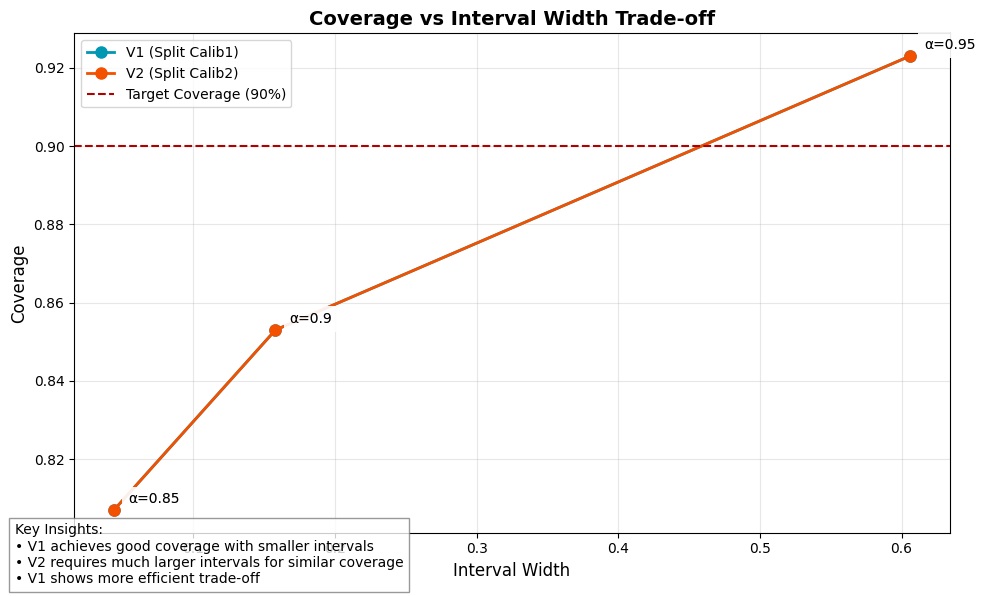

In [49]:
plt.figure(figsize=(10, 6))

# Scatter plot with connecting lines
plt.plot(conformal_metrics_last_v1["interval_width"], conformal_metrics_last_v1["coverage"], 
         '-o', label='V1 (Split Calib1)', color='#0097B2', linewidth=2, markersize=8)
plt.plot(conformal_metrics_last_v2["interval_width"], conformal_metrics_last_v2["coverage"], 
         '-o', label='V2 (Split Calib2)', color='#F35000', linewidth=2, markersize=8)

# Add alpha value annotations
for i, alpha in enumerate(conformal_metrics_last_v1["alpha"]):
    plt.annotate(f'α={alpha}', 
                (conformal_metrics_last_v1["interval_width"][i], conformal_metrics_last_v1["coverage"][i]),
                xytext=(10, 5), textcoords='offset points',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))
    plt.annotate(f'α={alpha}', 
                (conformal_metrics_last_v2["interval_width"][i], conformal_metrics_last_v2["coverage"][i]),
                xytext=(10, 5), textcoords='offset points',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

# Add reference line for desired coverage
plt.axhline(y=0.9, color='#B00000', linestyle='--', label='Target Coverage (90%)')

# Customize plot
plt.xlabel('Interval Width', fontsize=12)
plt.ylabel('Coverage', fontsize=12)
plt.title('Coverage vs Interval Width Trade-off', fontsize=14, weight='bold')
plt.grid(True, alpha=0.3)
plt.legend()

# Add text box with key insights
textstr = '\n'.join([
    'Key Insights:',
    '• V1 achieves good coverage with smaller intervals',
    '• V2 requires much larger intervals for similar coverage',
    '• V1 shows more efficient trade-off'
])

plt.figtext(0.02, 0.02, textstr, fontsize=10,
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

plt.tight_layout()
plt.show()

In [12]:
def run_multiple_conformal(X, y_binary, y_continuous, alpha_tilda=0.9, n_random_states=100):
    # Previous lists
    all_coverages = []
    all_widths = []
    all_nonzero_coverages = []
    all_nonzero_widths = []
    # New lists for beta tracking
    all_betas = []
    all_rs = []
    all_is_cpci = []
    
    random_states = np.random.choice(10000, size=n_random_states, replace=False)
    
    for rs in random_states:
        try:
            np.random.seed(rs)
            
            lower_bound, upper_bound, y_test, beta_hat, r_value, is_cpci = conformal_prediction_zero_inflated(
                X=X,
                y_binary=y_binary,
                y_continuous=y_continuous,
                alpha_tilda=alpha_tilda
            )
            
            # Calculate metrics
            coverage = np.mean((y_test >= lower_bound) & (y_test <= upper_bound))
            width = np.mean(upper_bound - lower_bound)
            
            nonzero_mask = y_test != 0
            nonzero_coverage = np.mean((y_test[nonzero_mask] >= lower_bound[nonzero_mask]) & 
                                     (y_test[nonzero_mask] <= upper_bound[nonzero_mask]))
            nonzero_width = np.mean(upper_bound[nonzero_mask] - lower_bound[nonzero_mask])
            
            # Store all results including beta
            all_coverages.append(coverage)
            all_widths.append(width)
            all_nonzero_coverages.append(nonzero_coverage)
            all_nonzero_widths.append(nonzero_width)
            all_betas.append(beta_hat)
            all_rs.append(r_value)
            all_is_cpci.append(is_cpci)
            
        except Exception as e:
            print(f"Error with random state {rs}: {str(e)}")
            continue
    
    results = {
        'mean_coverage': np.mean(all_coverages),
        'std_coverage': np.std(all_coverages),
        'mean_width': np.mean(all_widths),
        'std_width': np.std(all_widths),
        'mean_nonzero_coverage': np.mean(all_nonzero_coverages),
        'std_nonzero_coverage': np.std(all_nonzero_coverages),
        'mean_nonzero_width': np.mean(all_nonzero_widths),
        'std_nonzero_width': np.std(all_nonzero_widths),
        'mean_beta': np.mean(all_betas),
        'std_beta': np.std(all_betas),
        'mean_r': np.mean(all_rs),
        'std_r': np.std(all_rs),
        'cpci_percentage': np.mean(all_is_cpci) * 100
    }
    
    return results

# Run for different alpha values
alphas = [0.85, 0.9, 0.95]
all_results = {} #813110/829564

for alpha in alphas:
    print(f"\nRunning with alpha = {alpha}")
    results = run_multiple_conformal(
        X=X,
        y_binary=y_pred_all,
        y_continuous=normalized_pctg_change,
        alpha_tilda=alpha,
        n_random_states=100
    )
    
    all_results[alpha] = results
    
    print(f"Coverage: {results['mean_coverage']:.3f} ± {results['std_coverage']:.3f}")
    print(f"Width: {results['mean_width']:.3f} ± {results['std_width']:.3f}")
    print(f"Non-zero Coverage: {results['mean_nonzero_coverage']:.3f} ± {results['std_nonzero_coverage']:.3f}")
    print(f"Non-zero Width: {results['mean_nonzero_width']:.3f} ± {results['std_nonzero_width']:.3f}")
    print(f"Beta: {results['mean_beta']:.3f} ± {results['std_beta']:.3f}")
    print(f"r: {results['mean_r']:.3f} ± {results['std_r']:.3f}")
    print(f"CPCI used: {results['cpci_percentage']:.1f}% of the time")


Running with alpha = 0.85
Coverage: 0.803 ± 0.000
Width: 0.036 ± 0.000
Non-zero Coverage: 0.386 ± 0.000
Non-zero Width: 0.105 ± 0.000
Beta: 0.948 ± 0.000
r: 0.800 ± 0.000
CPCI used: 100.0% of the time

Running with alpha = 0.9
Coverage: 0.853 ± 0.000
Width: 0.158 ± 0.000
Non-zero Coverage: 0.505 ± 0.000
Non-zero Width: 0.468 ± 0.000
Beta: 0.948 ± 0.000
r: 0.800 ± 0.000
CPCI used: 100.0% of the time

Running with alpha = 0.95
Coverage: 0.923 ± 0.000
Width: 0.606 ± 0.000
Non-zero Coverage: 0.736 ± 0.000
Non-zero Width: 1.209 ± 0.000
Beta: 0.983 ± 0.000
r: 0.600 ± 0.000
CPCI used: 100.0% of the time


In [155]:
def cv_plus_conformal(X, y_binary, y_continuous, n_folds=10, alpha=0.9):
    """
    Cross-Validation+ conformal prediction implementation
    """
    # Convert to numpy arrays if they're pandas objects
    X_array = X.to_numpy() if hasattr(X, 'to_numpy') else np.array(X)
    y_binary_array = np.array(y_binary)
    y_continuous_array = np.array(y_continuous)
    
    n = len(X_array)
    fold_size = n // n_folds
    predictions = np.zeros(n)
    residuals = np.zeros(n)
    
    # Generate random fold assignments
    fold_indices = np.random.permutation(n)
    fold_assignments = np.array([i // fold_size for i in range(n)])
    
    # For each fold
    for fold in range(n_folds):
        train_mask = fold_assignments != fold
        val_mask = fold_assignments == fold
        
        classifier = xgb.XGBClassifier(**binary_params)
        classifier.fit(X_array[train_mask], y_binary_array[train_mask])
        
        mask_nonzero = y_binary_array[train_mask] == 1
        regressor = xgb.XGBRegressor(**regression_params_short)
        regressor.fit(X_array[train_mask][mask_nonzero], 
                     y_continuous_array[train_mask][mask_nonzero])
        
        val_probs = classifier.predict_proba(X_array[val_mask])[:, 1]
        val_pred = regressor.predict(X_array[val_mask])
        
        predictions[val_mask] = val_pred
        residuals[val_mask] = np.abs(y_continuous_array[val_mask] - val_pred)
    
    quantile = np.quantile(residuals, alpha)
    return predictions, quantile

In [154]:
def jackknife_plus_ab_conformal(X, y_binary, y_continuous, n_resamplings=50, alpha=0.9):
    """
    Jackknife+AB conformal prediction implementation
    """
    # Convert to numpy arrays if they're pandas objects
    X_array = X.to_numpy() if hasattr(X, 'to_numpy') else np.array(X)
    y_binary_array = np.array(y_binary)
    y_continuous_array = np.array(y_continuous)
    
    n = len(X_array)
    predictions = np.zeros((n, n_resamplings))
    residuals = np.zeros((n, n_resamplings))
    
    for b in range(n_resamplings):
        bootstrap_indices = np.random.choice(n, size=n, replace=True)
        oob_mask = ~np.isin(np.arange(n), bootstrap_indices)
        
        classifier = xgb.XGBClassifier(**binary_params)
        classifier.fit(X_array[bootstrap_indices], y_binary_array[bootstrap_indices])
        
        mask_nonzero = y_binary_array[bootstrap_indices] == 1
        regressor = xgb.XGBRegressor(**regression_params_short)
        regressor.fit(X_array[bootstrap_indices][mask_nonzero], 
                     y_continuous_array[bootstrap_indices][mask_nonzero])
        
        if any(oob_mask):  # Only predict if there are out-of-bag samples
            oob_probs = classifier.predict_proba(X_array[oob_mask])[:, 1]
            oob_pred = regressor.predict(X_array[oob_mask])
            predictions[oob_mask, b] = oob_pred
            residuals[oob_mask, b] = np.abs(y_continuous_array[oob_mask] - oob_pred)
    
    mean_predictions = np.nanmean(predictions, axis=1)
    max_residuals = np.nanmax(residuals, axis=1)
    quantile = np.quantile(max_residuals[~np.isnan(max_residuals)], alpha)
    
    return mean_predictions, quantile

In [156]:
def conformal_prediction_with_method(X, y_binary, y_continuous, method='cv_plus', alpha=0.9):
    if method == 'cv_plus':
        predictions, quantile = cv_plus_conformal(X, y_binary, y_continuous, alpha=alpha)
    elif method == 'jackknife_plus_ab':
        predictions, quantile = jackknife_plus_ab_conformal(X, y_binary, y_continuous, alpha=alpha)
    else:
        raise ValueError("Method must be 'cv_plus' or 'jackknife_plus_ab'")
    
    # Create prediction intervals
    lower_bound = predictions - quantile
    upper_bound = predictions + quantile
    
    # Set intervals to [0,0] for predicted zeros
    zero_mask = y_binary == 0
    lower_bound[zero_mask] = 0
    upper_bound[zero_mask] = 0
    
    return lower_bound, upper_bound


Results for cv_plus:
Alpha	Coverage	Width	Nonzero Coverage	Nonzero Width
0.70	0.700	1.176	0.564	1.176
0.75	0.750	1.297	0.619	1.297
0.80	0.803	1.392	0.635	1.392
0.85	0.850	1.584	0.729	1.584
0.90	0.907	1.859	0.782	1.859

Results for jackknife_plus_ab:
Alpha	Coverage	Width	Nonzero Coverage	Nonzero Width
0.70	0.976	1.541	0.979	1.541
0.75	0.980	1.605	0.989	1.605
0.80	0.987	1.746	0.993	1.746
0.85	0.992	1.840	0.998	1.840
0.90	0.995	1.963	0.998	1.963


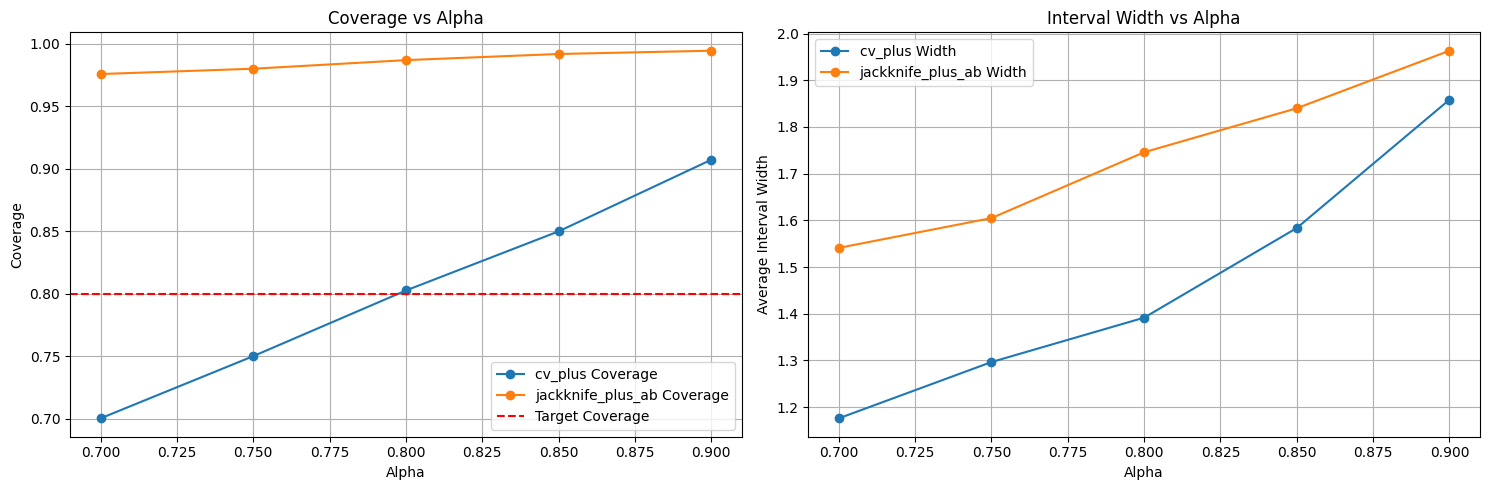

In [157]:
# 1. First define the methods with parameters you want to test
methods = {
    "cv_plus": {"n_folds": 10},
    "jackknife_plus_ab": {"n_resamplings": 50}
}

alphas = [0.7, 0.75, 0.8, 0.85, 0.9]

# 2. Create dictionaries to store results
results = {
    method: {
        "coverage": [],
        "interval_width": [],
        "nonzero_coverage": [],
        "nonzero_width": []
    } 
    for method in methods
}

# 3. Run the experiment
for method_name in methods:
    for alpha in alphas:
        if method_name == "cv_plus":
            predictions, quantile = cv_plus_conformal(
                X=X,
                y_binary=y_pred_all,  # Your binary predictions
                y_continuous=normalized_pctg_change,
                n_folds=methods[method_name]["n_folds"],
                alpha=alpha
            )
        else:  # jackknife_plus_ab
            predictions, quantile = jackknife_plus_ab_conformal(
                X=X,
                y_binary=y_pred_all,  # Your binary predictions
                y_continuous=normalized_pctg_change,
                n_resamplings=methods[method_name]["n_resamplings"],
                alpha=alpha
            )
        
        # Create intervals
        lower_bound = predictions - quantile
        upper_bound = predictions + quantile
        
        # Calculate metrics
        coverage = np.mean((normalized_pctg_change >= lower_bound) & 
                         (normalized_pctg_change <= upper_bound))
        interval_width = np.mean(upper_bound - lower_bound)
        
        # Calculate non-zero metrics
        nonzero_mask = y_pred_all == 1
        nonzero_coverage = np.mean((normalized_pctg_change[nonzero_mask] >= lower_bound[nonzero_mask]) & 
                                 (normalized_pctg_change[nonzero_mask] <= upper_bound[nonzero_mask]))
        nonzero_width = np.mean(upper_bound[nonzero_mask] - lower_bound[nonzero_mask])
        
        # Store results
        results[method_name]["coverage"].append(coverage)
        results[method_name]["interval_width"].append(interval_width)
        results[method_name]["nonzero_coverage"].append(nonzero_coverage)
        results[method_name]["nonzero_width"].append(nonzero_width)

# 4. Print results
for method_name in methods:
    print(f"\nResults for {method_name}:")
    print("Alpha\tCoverage\tWidth\tNonzero Coverage\tNonzero Width")
    for i, alpha in enumerate(alphas):
        print(f"{alpha:.2f}\t{results[method_name]['coverage'][i]:.3f}\t"
              f"{results[method_name]['interval_width'][i]:.3f}\t"
              f"{results[method_name]['nonzero_coverage'][i]:.3f}\t"
              f"{results[method_name]['nonzero_width'][i]:.3f}")

# 5. Visualize results
plt.figure(figsize=(15, 5))

# Coverage plot
plt.subplot(1, 2, 1)
for method_name in methods:
    plt.plot(alphas, results[method_name]["coverage"], 
             marker='o', label=f"{method_name} Coverage")
plt.axhline(y=0.8, color='r', linestyle='--', label='Target Coverage')
plt.xlabel('Alpha')
plt.ylabel('Coverage')
plt.title('Coverage vs Alpha')
plt.legend()
plt.grid(True)

# Width plot
plt.subplot(1, 2, 2)
for method_name in methods:
    plt.plot(alphas, results[method_name]["interval_width"], 
             marker='o', label=f"{method_name} Width")
plt.xlabel('Alpha')
plt.ylabel('Average Interval Width')
plt.title('Interval Width vs Alpha')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

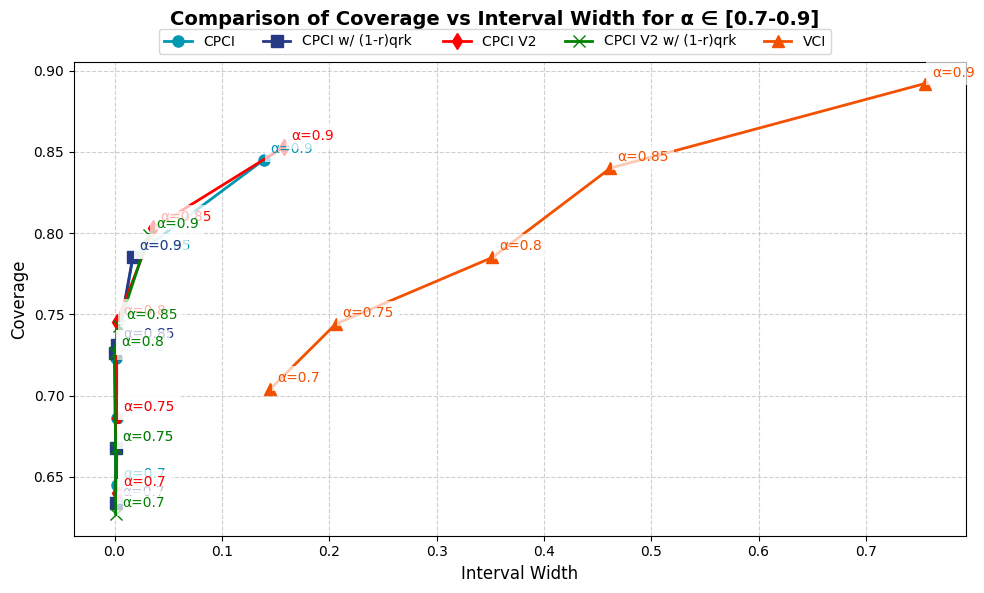

In [58]:
# Data for plotting
conformal_metrics_new = {
    "alpha": [0.7, 0.75, 0.8, 0.85, 0.9],
    "coverage": [0.645, 0.686, 0.723, 0.785, 0.845],
    "interval_width": [0.002, 0.002, 0.001, 0.017, 0.139]
}
conformal_metrics_modified = {
    "alpha": [0.7, 0.75, 0.8, 0.85, 0.9],
    "coverage": [0.634, 0.668, 0.726, 0.731, 0.785],
    "interval_width": [0.001, 0.001, 0.000, 0.002, 0.017]
}
conformal_metrics_new_v2 = {
    "alpha": [0.7, 0.75, 0.8, 0.85, 0.9],
    "coverage": [0.640, 0.686, 0.745, 0.803, 0.853],
    "interval_width": [0.002, 0.002, 0.002, 0.036, 0.158]
}
conformal_metrics_modified_v2 = {
    "alpha": [0.7, 0.75, 0.8, 0.85, 0.9],
    "coverage": [0.627, 0.668, 0.726, 0.743, 0.799],
    "interval_width": [0.001, 0.001, 0.000, 0.004, 0.032]
}
conformal_metrics_vanilla = {
    "alpha": [0.7, 0.75, 0.8, 0.85, 0.9],
    "coverage": [0.704, 0.744, 0.785, 0.840, 0.892],
    "interval_width": [0.145, 0.206, 0.352, 0.462, 0.755]
}


fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle('Comparison of Coverage vs Interval Width for α ∈ [0.7-0.9]', fontsize=14, weight='bold')

# Plotting each method
methods = {
    "CPCI": ("#0097B2", "o", conformal_metrics_new),
    "CPCI w/ (1-r)qrk ": ("#263985", "s", conformal_metrics_modified),
    "CPCI V2": ("red", "d", conformal_metrics_new_v2),
    "CPCI V2 w/ (1-r)qrk": ("green", "x", conformal_metrics_modified_v2),
    "VCI": ("#F35000", "^", conformal_metrics_vanilla),
}

for label, (color, marker, data) in methods.items():
    ax.plot(data["interval_width"], data["coverage"], 
             marker=marker, color=color, linewidth=2, markersize=8, label=label)
    for i, alpha in enumerate(data["alpha"]):
        ax.annotate(f'α={alpha}',(data["interval_width"][i], data["coverage"][i]), xytext=(5, 5), textcoords='offset points', fontsize=10, bbox=dict(facecolor='white', edgecolor='none', alpha=0.7), color=color)

# Add reference lines and shaded regions
# ax.axhline(y=0.8, linestyle='--', color='#B00000', linewidth=1.5, label='Target Coverage (80%)')
# ax.axhspan(0.8, 1.0, alpha=0.1, color='red', label='Target Coverage Zone')

# Customize plot
ax.set_xlabel('Interval Width', fontsize=12)
ax.set_ylabel('Coverage', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.6)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=5, fontsize=10, bbox_to_anchor=(0.5, 0.96), frameon=True)
plt.tight_layout(rect=[0, 0, 1, 0.975])
plt.savefig('conformal_comparison.png', transparent=True, bbox_inches='tight')
plt.show()

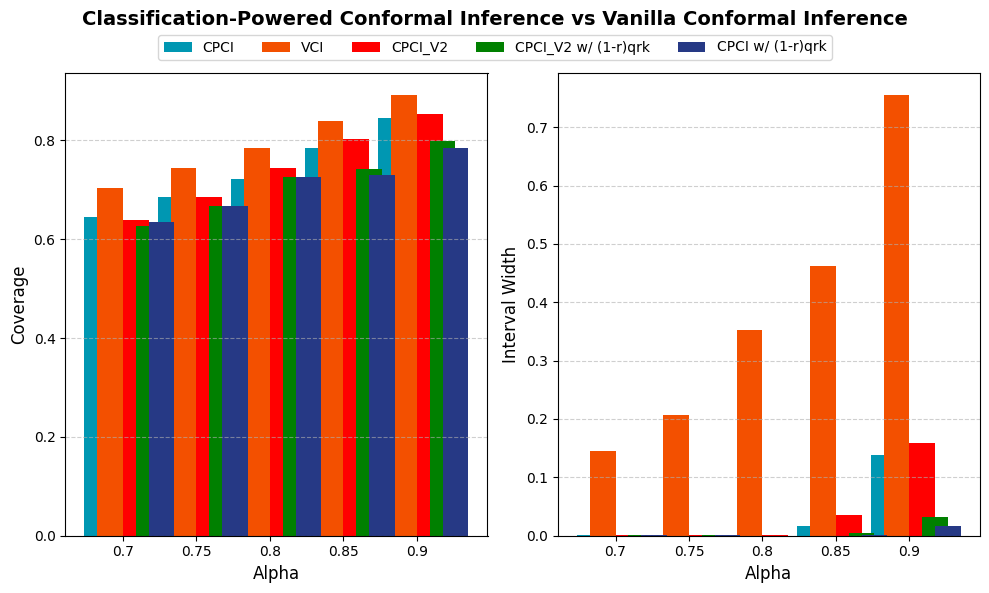

In [59]:
width = 0.35  # Bar width
x = np.arange(len(conformal_metrics_new["alpha"]))
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 6))
ax1.bar(x - 2 * width / 2, conformal_metrics_new["coverage"], width, label='CPCI', color='#0097B2')
ax1.bar(x - width / 2, conformal_metrics_vanilla["coverage"], width, label='VCI', color='#F35000')
ax1.bar(x + width / 2, conformal_metrics_new_v2["coverage"], width, label='CPCI_V2', color='red')
ax1.bar(x + 2 * width / 2, conformal_metrics_modified_v2["coverage"], width, label='CPCI_V2 w/ (1-r)qrk', color='green')
ax1.bar(x + 3 * width / 2, conformal_metrics_modified["coverage"], width, label='CPCI w/ (1-r)qrk', color='#263985')
ax1.set_xticks(x)
ax1.set_xticklabels(conformal_metrics_new["alpha"])
ax1.set_xlabel('Alpha', fontsize=12)
ax1.set_ylabel('Coverage', fontsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.6)

ax2.bar(x - 2 * width / 2, conformal_metrics_new["interval_width"], width, color='#0097B2')
ax2.bar(x - width / 2, conformal_metrics_vanilla["interval_width"], width, color='#F35000')
ax2.bar(x + width / 2, conformal_metrics_new_v2["interval_width"], width, color='red')
ax2.bar(x + 2 * width / 2, conformal_metrics_modified_v2["interval_width"], width, color='green')
ax2.bar(x + 3 * width / 2, conformal_metrics_modified["interval_width"], width, color='#263985')
ax2.set_xticks(x)
ax2.set_xticklabels(conformal_metrics_new["alpha"])
ax2.set_xlabel('Alpha', fontsize=12)
ax2.set_ylabel('Interval Width', fontsize=12)
ax2.grid(axis='y', linestyle='--', alpha=0.6)
# ax2.set_yscale('log')
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=5, fontsize=10, bbox_to_anchor=(0.5, 0.95), frameon=True)
plt.tight_layout(rect=[0, 0, 1, 0.9]) 
fig.suptitle('Classification-Powered Conformal Inference vs Vanilla Conformal Inference', fontsize=14, weight='bold')
plt.savefig('conformal_comparison_v2.png', transparent=True, bbox_inches='tight')
plt.show()

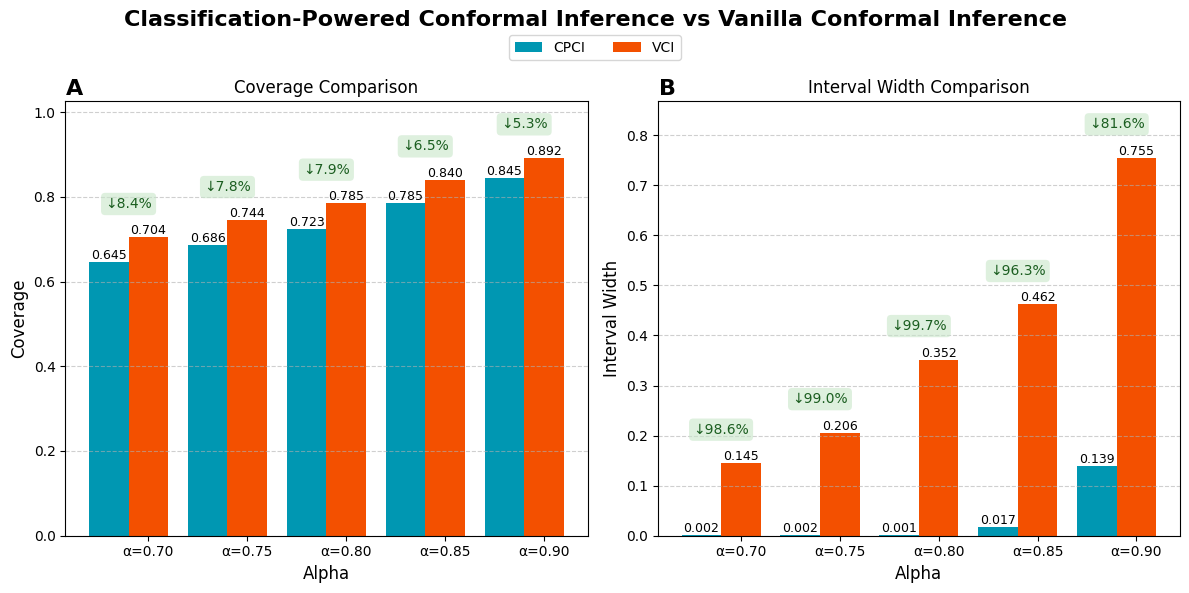

In [60]:
width = 0.4  # Adjusted bar width
x = np.arange(len(conformal_metrics_new["alpha"]))

# Compute differences
diff_coverage = (np.array(conformal_metrics_vanilla["coverage"]) - np.array(conformal_metrics_new["coverage"])) / np.array(conformal_metrics_vanilla["coverage"]) * 100
diff_interval = (np.array(conformal_metrics_vanilla["interval_width"]) - np.array(conformal_metrics_new["interval_width"])) / np.array(conformal_metrics_vanilla["interval_width"]) * 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Classification-Powered Conformal Inference vs Vanilla Conformal Inference', fontsize=16, weight='bold')

# Coverage Comparison
bar1 = ax1.bar(x - width, conformal_metrics_new["coverage"], width, label='CPCI', color='#0097B2')
bar2 = ax1.bar(x, conformal_metrics_vanilla["coverage"], width, label='VCI', color='#F35000')

def add_value_labels(bars, ax):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

add_value_labels(bar1, ax1)
add_value_labels(bar2, ax1)

# Set y-axis limits with padding for annotations
max_coverage = max(max(conformal_metrics_new["coverage"]), max(conformal_metrics_vanilla["coverage"]))
ax1.set_ylim(0, max_coverage * 1.15)  # Add 15% padding

ax1.set_xticks(x)
ax1.set_xticklabels([f'α={alpha:.2f}' for alpha in conformal_metrics_new["alpha"]])
ax1.set_xlabel('Alpha', fontsize=12)
ax1.set_ylabel('Coverage', fontsize=12)
ax1.set_title('Coverage Comparison', fontsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.6)

# Interval Width Comparison
bar3 = ax2.bar(x - width, conformal_metrics_new["interval_width"], width, color='#0097B2')
bar4 = ax2.bar(x, conformal_metrics_vanilla["interval_width"], width, color='#F35000')

add_value_labels(bar3, ax2)
add_value_labels(bar4, ax2)

# Set y-axis limits with padding for annotations
max_interval = max(max(conformal_metrics_new["interval_width"]), max(conformal_metrics_vanilla["interval_width"]))
ax2.set_ylim(0, max_interval * 1.15)  # Add 15% padding

ax2.set_xticks(x)
ax2.set_xticklabels([f'α={alpha:.2f}' for alpha in conformal_metrics_new["alpha"]])

ax2.set_xlabel('Alpha', fontsize=12)
ax2.set_ylabel('Interval Width', fontsize=12)
ax2.set_title('Interval Width Comparison', fontsize=12)
ax2.grid(axis='y', linestyle='--', alpha=0.6)

# Define annotation properties
bbox_props = dict(boxstyle="round,pad=0.3", fc='#C8E6C9', ec="none", alpha=0.6)

for i, (diff_cov, diff_int) in enumerate(zip(diff_coverage, diff_interval)):
    # Coverage reduction
    max_cov = max(conformal_metrics_new["coverage"][i], conformal_metrics_vanilla["coverage"][i])
    annotation_height_cov = max_cov + (max_coverage * 0.07)  # Position at 3% above the bar
    
    if diff_cov > 0:
        ax1.text(x[i] - width/2, annotation_height_cov,
                f'↓{abs(diff_cov):.1f}%', ha='center', va='bottom', 
                fontsize=10, color='#1B5E20', bbox=bbox_props)
    else:
        ax1.text(x[i] - width/2, annotation_height_cov,
                f'↑{abs(diff_cov):.1f}%', ha='center', va='bottom', 
                fontsize=10, color='red', bbox=bbox_props)

    # Interval width reduction
    max_int = max(conformal_metrics_new["interval_width"][i], conformal_metrics_vanilla["interval_width"][i])
    annotation_height_int = max_int + (max_interval * 0.07)  # Position at 3% above the bar
    
    if diff_int > 0:
        ax2.text(x[i] - width/2, annotation_height_int,
                f'↓{abs(diff_int):.1f}%', ha='center', va='bottom', 
                fontsize=10, color='#1B5E20', bbox=bbox_props)
    else:
        ax2.text(x[i] - width/2, annotation_height_int,
                f'↑{abs(diff_int):.1f}%', ha='center', va='bottom', 
                fontsize=10, color='red', bbox=bbox_props)
        
# Add letters A and B to the subplots
ax1.text(0.035, 1.05, 'A', transform=ax1.transAxes, 
         fontsize=16, fontweight='bold', va='top', ha='right')
ax2.text(0.035, 1.05, 'B', transform=ax2.transAxes, 
         fontsize=16, fontweight='bold', va='top', ha='right')

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=3, fontsize=10, 
          bbox_to_anchor=(0.5, 0.95), frameon=True)

# Adjust layout and show
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('CPCI_vs_VCI.png', transparent=True, bbox_inches='tight')
plt.show()

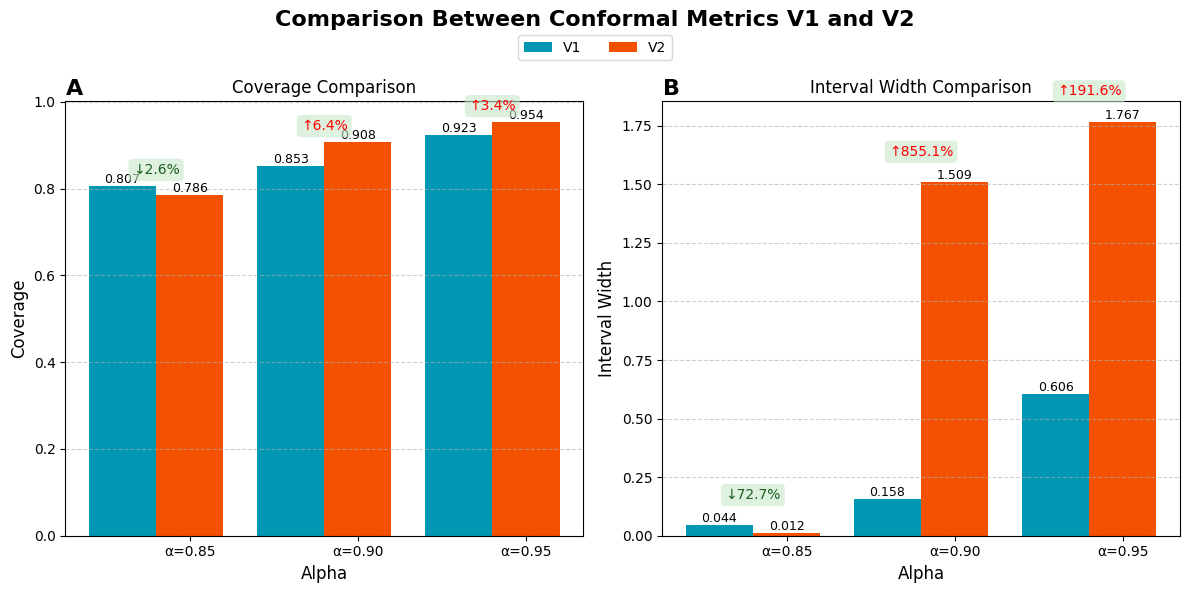

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Data
conformal_metrics_last_v1 = {
    "alpha": [0.85, 0.9, 0.95],
    "coverage": [0.807, 0.853, 0.923],
    "interval_width": [0.044, 0.158, 0.606]
}
conformal_metrics_last_v2 = {
    "alpha": [0.85, 0.9, 0.95],
    "coverage": [0.786, 0.908, 0.954],
    "interval_width": [0.012, 1.509, 1.767]
}

# Bar width and x-axis positions
width = 0.4
x = np.arange(len(conformal_metrics_last_v1["alpha"]))

# Compute percentage differences
diff_coverage = (np.array(conformal_metrics_last_v1["coverage"]) - np.array(conformal_metrics_last_v2["coverage"])) / np.array(conformal_metrics_last_v1["coverage"]) * 100
diff_interval = (np.array(conformal_metrics_last_v1["interval_width"]) - np.array(conformal_metrics_last_v2["interval_width"])) / np.array(conformal_metrics_last_v1["interval_width"]) * 100

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
fig.suptitle('Comparison Between Conformal Metrics V1 and V2', fontsize=16, weight='bold')

# Coverage Comparison
bar1 = ax1.bar(x - width, conformal_metrics_last_v1["coverage"], width, label='V1', color='#0097B2')
bar2 = ax1.bar(x, conformal_metrics_last_v2["coverage"], width, label='V2', color='#F35000')

# Interval Width Comparison
bar3 = ax2.bar(x - width, conformal_metrics_last_v1["interval_width"], width, label='V1', color='#0097B2')
bar4 = ax2.bar(x, conformal_metrics_last_v2["interval_width"], width, label='V2', color='#F35000')

# Add value labels
def add_value_labels(bars, ax):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height, f'{height:.3f}', ha='center', va='bottom', fontsize=9)

add_value_labels(bar1, ax1)
add_value_labels(bar2, ax1)
add_value_labels(bar3, ax2)
add_value_labels(bar4, ax2)

# Annotate percentage differences
bbox_props = dict(boxstyle="round,pad=0.3", fc='#C8E6C9', ec="none", alpha=0.6)

for i, (diff_cov, diff_int) in enumerate(zip(diff_coverage, diff_interval)):
    # Coverage annotations
    max_cov = max(conformal_metrics_last_v1["coverage"][i], conformal_metrics_last_v2["coverage"][i])
    annotation_height_cov = max_cov + 0.02  # Slightly above the highest bar
    ax1.text(x[i] - width/2, annotation_height_cov, f'↓{abs(diff_cov):.1f}%' if diff_cov > 0 else f'↑{abs(diff_cov):.1f}%',
             ha='center', va='bottom', fontsize=10, color='#1B5E20' if diff_cov > 0 else 'red', bbox=bbox_props)

    # Interval annotations
    max_int = max(conformal_metrics_last_v1["interval_width"][i], conformal_metrics_last_v2["interval_width"][i])
    annotation_height_int = max_int + 0.1  # Slightly above the highest bar
    ax2.text(x[i] - width/2, annotation_height_int, f'↓{abs(diff_int):.1f}%' if diff_int > 0 else f'↑{abs(diff_int):.1f}%',
             ha='center', va='bottom', fontsize=10, color='#1B5E20' if diff_int > 0 else 'red', bbox=bbox_props)

# Axis labels and titles
ax1.set_xticks(x)
ax1.set_xticklabels([f'α={alpha:.2f}' for alpha in conformal_metrics_last_v1["alpha"]])
ax1.set_xlabel('Alpha', fontsize=12)
ax1.set_ylabel('Coverage', fontsize=12)
ax1.set_title('Coverage Comparison', fontsize=12)
ax1.grid(axis='y', linestyle='--', alpha=0.6)

ax2.set_xticks(x)
ax2.set_xticklabels([f'α={alpha:.2f}' for alpha in conformal_metrics_last_v1["alpha"]])
ax2.set_xlabel('Alpha', fontsize=12)
ax2.set_ylabel('Interval Width', fontsize=12)
ax2.set_title('Interval Width Comparison', fontsize=12)
ax2.grid(axis='y', linestyle='--', alpha=0.6)

# Add letters A and B to the subplots
ax1.text(0.035, 1.05, 'A', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')
ax2.text(0.035, 1.05, 'B', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Add legend
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=10, bbox_to_anchor=(0.5, 0.95), frameon=True)

# Adjust layout and show plot
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('Conformal_Metrics_V1_vs_V2.png', transparent=True, bbox_inches='tight')
plt.show()

In [89]:
def conformal_prediction_zero_inflated_mapie(X, y_binary, y_continuous, alpha_tilda=0.9):
    """
    Two-stage conformal prediction using MAPIE for regression intervals.
    First stage: XGBoost classifier to predict zero/non-zero
    Second stage: MAPIE with XGBoost regressor for prediction intervals
    """
    # Split data into five parts
    (X_train, X_calib1, X_calib2, X_calib3, X_test,
     y_binary_train, y_binary_calib1, y_binary_calib2, y_binary_calib3, y_binary_test,
     y_cont_train, y_cont_calib1, y_cont_calib2, y_cont_calib3, y_cont_test) = split_into_five_equal_parts(
        X, y_binary, y_continuous
    )
    
    # First stage: Classification model
    classifier = xgb.XGBClassifier(**binary_params)
    classifier.fit(X_train, y_binary_train)
    
    # Get probabilities for calibration set 1
    probs_calib1 = classifier.predict_proba(X_calib1)[:, 1]
    
    # Try different r values
    r_values = np.arange(0.1, 0.95, 0.05)
    all_interval_lengths = []
    
    # Initialize MAPIE with XGBoost regressor
    regressor = xgb.XGBRegressor(**regression_params_short)
    mapie = MapieRegressor(
        estimator=regressor,
        method="plus",  # Jack-knife+ method
        cv="prefit",
        random_state=42
    )
    
    # Fit regressor on non-zero training data
    mask_nonzero = y_binary_train == 1
    regressor.fit(X_train[mask_nonzero], y_cont_train[mask_nonzero])
    
    for r in r_values:
        # First calibration: threshold for zero/non-zero
        alpha_r = np.quantile(probs_calib1, r)
        
        # Second calibration: accuracy of zero predictions
        probs_calib2 = classifier.predict_proba(X_calib2)[:, 1]
        pred_zeros = probs_calib2 <= alpha_r
        beta_hat = np.mean(y_binary_calib2[pred_zeros] == 0)
        
        # Calculate final quantile
        final_quantile = (alpha_tilda - beta_hat * r) / (1 - r)
        if final_quantile < 0 or final_quantile > 1:
            continue
            
        # Third calibration: Use MAPIE for interval width
        probs_calib3 = classifier.predict_proba(X_calib3)[:, 1]
        nonzero_mask = probs_calib3 > alpha_r
        if not any(nonzero_mask):
            continue
        
        # Fit MAPIE on non-zero calibration data
        X_calib3_nonzero = X_calib3[nonzero_mask]
        y_calib3_nonzero = y_cont_calib3[nonzero_mask]
        
        # Get MAPIE prediction intervals
        mapie.fit(X_calib3_nonzero, y_calib3_nonzero)
        _, y_pis = mapie.predict(X_calib3_nonzero, alpha=final_quantile)
        
        # Calculate interval width as mean of MAPIE intervals
        interval_width = np.mean(y_pis[:, 1, 0] - y_pis[:, 0, 0])
        all_interval_lengths.append((r, interval_width, alpha_r))
    
    if not all_interval_lengths:
        raise ValueError("No valid intervals found. Try adjusting r_values or alpha_tilda.")
    
    # Choose best r value
    best_r, best_width, best_alpha_r = min(all_interval_lengths, key=lambda x: x[1])
    
    # Final predictions on test set
    test_probs = classifier.predict_proba(X_test)[:, 1]
    nonzero_mask_test = test_probs > best_alpha_r
    
    # Initialize bounds
    lower_bound = np.zeros(len(X_test))
    upper_bound = np.zeros(len(X_test))
    
    if any(nonzero_mask_test):
        # Get MAPIE predictions for non-zero cases
        _, y_pis_test = mapie.predict(X_test[nonzero_mask_test], alpha=0.8)
        lower_bound[nonzero_mask_test] = y_pis_test[:, 0, 0]
        upper_bound[nonzero_mask_test] = y_pis_test[:, 1, 0]
    
    return lower_bound, upper_bound, y_cont_test

# Usage
lower_bound_mapie, upper_bound_mapie, y_test_mapie = conformal_prediction_zero_inflated_mapie(
    X=X,
    y_binary=y_pred_all,
    y_continuous=normalized_pctg_change,
    alpha_tilda=0.9
)

# Calculate coverage and interval width
coverage_mapie = np.mean((y_test_mapie >= lower_bound_mapie) & (y_test_mapie <= upper_bound_mapie))
interval_width_mapie = np.mean(upper_bound_mapie - lower_bound_mapie)
print(f"MAPIE Coverage: {coverage_mapie:.3f}")
print(f"MAPIE Average interval width: {interval_width_mapie:.3f}")

MAPIE Coverage: 0.735
MAPIE Average interval width: 0.003


In [87]:
def conformal_prediction_zero_inflated_mapie(X, y_binary, y_continuous, alpha_tilda=0.9):
    """
    Two-stage conformal prediction using MAPIE for regression intervals.
    """
    # Split data into five parts
    (X_train, X_calib1, X_calib2, X_calib3, X_test,
     y_binary_train, y_binary_calib1, y_binary_calib2, y_binary_calib3, y_binary_test,
     y_cont_train, y_cont_calib1, y_cont_calib2, y_cont_calib3, y_cont_test) = split_into_five_equal_parts(
        X, y_binary, y_continuous
    )
    
    # First stage: Classification model
    classifier = xgb.XGBClassifier(**binary_params)
    classifier.fit(X_train, y_binary_train)
    
    # Get probabilities for calibration set 1
    probs_calib1 = classifier.predict_proba(X_calib1)[:, 1]
    
    # Try different r values
    r_values = np.arange(0.1, 0.95, 0.05)
    all_interval_lengths = []
    
    # Initialize MAPIE with XGBoost regressor
    regressor = xgb.XGBRegressor(**regression_params_short)
    
    # Fit regressor on non-zero training data
    mask_nonzero = y_binary_train == 1
    regressor.fit(X_train[mask_nonzero], y_cont_train[mask_nonzero])
    
    # Initialize MAPIE with the fitted regressor
    mapie = MapieRegressor(
        estimator=regressor,
        method="plus",
        cv="prefit",
        random_state=42
    )
    
    for r in r_values:
        # First calibration: threshold for zero/non-zero
        alpha_r = np.quantile(probs_calib1, r)
        
        # Second calibration: accuracy of zero predictions
        probs_calib2 = classifier.predict_proba(X_calib2)[:, 1]
        pred_zeros = probs_calib2 <= alpha_r
        beta_hat = np.mean(y_binary_calib2[pred_zeros] == 0)
        
        # Calculate final quantile and ensure it's in [0,1]
        final_quantile = (alpha_tilda - beta_hat * r) / (1 - r)
        final_quantile = np.clip(final_quantile, 0.01, 0.99)  # Clip to valid range
        
        # Third calibration: Use MAPIE for interval width
        probs_calib3 = classifier.predict_proba(X_calib3)[:, 1]
        nonzero_mask = probs_calib3 > alpha_r
        if not any(nonzero_mask):
            continue
        
        # Fit MAPIE on non-zero calibration data
        X_calib3_nonzero = X_calib3[nonzero_mask]
        y_calib3_nonzero = y_cont_calib3[nonzero_mask]
        
        try:
            # Get MAPIE prediction intervals
            mapie.fit(X_calib3_nonzero, y_calib3_nonzero)
            _, y_pis = mapie.predict(X_calib3_nonzero, alpha=final_quantile)
            
            # Calculate interval width as mean of MAPIE intervals
            interval_width = np.mean(y_pis[:, 1, 0] - y_pis[:, 0, 0])
            all_interval_lengths.append((r, interval_width, alpha_r))
        except Exception as e:
            print(f"Skipping r={r} due to error: {e}")
            continue
    
    if not all_interval_lengths:
        raise ValueError("No valid intervals found. Try adjusting r_values or alpha_tilda.")
    
    # Choose best r value
    best_r, best_width, best_alpha_r = min(all_interval_lengths, key=lambda x: x[1])
    
    # Final predictions on test set
    test_probs = classifier.predict_proba(X_test)[:, 1]
    nonzero_mask_test = test_probs > best_alpha_r
    
    # Initialize bounds
    lower_bound = np.zeros(len(X_test))
    upper_bound = np.zeros(len(X_test))
    
    if any(nonzero_mask_test):
        # Get MAPIE predictions for non-zero cases
        _, y_pis_test = mapie.predict(X_test[nonzero_mask_test], alpha=0.9)  # Use fixed alpha for final prediction
        lower_bound[nonzero_mask_test] = y_pis_test[:, 0, 0]
        upper_bound[nonzero_mask_test] = y_pis_test[:, 1, 0]
    
    return lower_bound, upper_bound, y_cont_test

In [88]:
lower_bound_mapie, upper_bound_mapie, y_test_mapie = conformal_prediction_zero_inflated_mapie(
    X=X,
    y_binary=y_pred_all,
    y_continuous=normalized_pctg_change,
    alpha_tilda=0.9
)

# Calculate coverage and interval width
coverage_mapie = np.mean((y_test_mapie >= lower_bound_mapie) & (y_test_mapie <= upper_bound_mapie))
interval_width_mapie = np.mean(upper_bound_mapie - lower_bound_mapie)
print(f"MAPIE Coverage: {coverage_mapie:.3f}")
print(f"MAPIE Average interval width: {interval_width_mapie:.3f}")

MAPIE Coverage: 0.737
MAPIE Average interval width: 0.001


In [114]:
from matplotlib.ticker import FormatStrFormatter
from matplotlib.offsetbox import AnnotationBbox, TextArea

round_to = 2

def sort_y_values(y_test, y_pred, y_pis):
    """
    Sorting the dataset in order to make plots using the fill_between function.
    """
    indices = np.argsort(y_test)
    y_test_sorted = np.array(y_test)[indices]
    y_pred_sorted = y_pred[indices]
    y_lower_bound = y_pis[:, 0, 0][indices]
    y_upper_bound = y_pis[:, 1, 0][indices]
    return y_test_sorted, y_pred_sorted, y_lower_bound, y_upper_bound


def plot_prediction_intervals(
    title,
    axs,
    y_test_sorted,
    y_pred_sorted,
    lower_bound,
    upper_bound,
    coverage,
    width,
    num_plots_idx
):
    """
    Plot of the prediction intervals for each different conformal
    method.
    """
    # axs.yaxis.set_major_formatter(FormatStrFormatter('%.0f' + "k"))
    # axs.xaxis.set_major_formatter(FormatStrFormatter('%.0f' + "k"))

    lower_bound_ = np.take(lower_bound, num_plots_idx)
    y_pred_sorted_ = np.take(y_pred_sorted, num_plots_idx)
    y_test_sorted_ = np.take(y_test_sorted, num_plots_idx)

    error = y_pred_sorted_-lower_bound_

    warning1 = y_test_sorted_ > y_pred_sorted_+error
    warning2 = y_test_sorted_ < y_pred_sorted_-error
    warnings = warning1 + warning2
    axs.errorbar(
        y_test_sorted_[~warnings],
        y_pred_sorted_[~warnings],
        yerr=np.abs(error[~warnings]),
        capsize=5, marker="o", elinewidth=2, linewidth=0,
        label="Inside prediction interval"
        )
    # axs.errorbar(
    #     y_test_sorted_[warnings],
    #     y_pred_sorted_[warnings],
    #     yerr=np.abs(error[warnings]),
    #     capsize=5, marker="x", elinewidth=2, linewidth=0, color="red",
    #     label="Outside prediction interval"
    #     )
    axs.scatter(
        y_test_sorted_[warnings],
        y_test_sorted_[warnings],
        marker="*", color="green",
        label="True value"
    )
    axs.set_xlabel("True Percent Change of LEDD")
    axs.set_ylabel("Prediction of Percent Change of LEDD")
    lims = [
    np.min([axs.get_xlim(), axs.get_ylim()]),  # min of both axes
    np.max([axs.get_xlim(), axs.get_ylim()]),  # max of both axes
]
    # lims = [-1,1]
    ab = AnnotationBbox(
    TextArea(
        f"Coverage: {np.round(coverage, round_to)}\n"
        + f"Interval width: {np.round(width, round_to)}"
    ),
    xy=(lims[0] * 0.9, lims[1] * 0.9),  # Position annotation more relative to axis limits
    xycoords='data',
    boxcoords="offset points",
    frameon=True
    )
    axs.grid(True)
    axs.set_xlim(lims)
    axs.set_ylim(lims)
    axs.plot(lims, lims, '--', alpha=0.75, color="black", label="x=y")
    axs.add_artist(ab)
    axs.set_title(title, fontweight='bold')

/opt/conda/lib/python3.10/site-packages/mapie/utils.py:598: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/mapie/utils.py:598: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/mapie/utils.py:598: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(



Strategy: naive
Coverage: 0.734
Average interval width: 0.000

Strategy: cv_plus
Coverage: 0.732
Average interval width: 0.011

Strategy: jackknife_plus_ab
Coverage: 0.729
Average interval width: 0.004


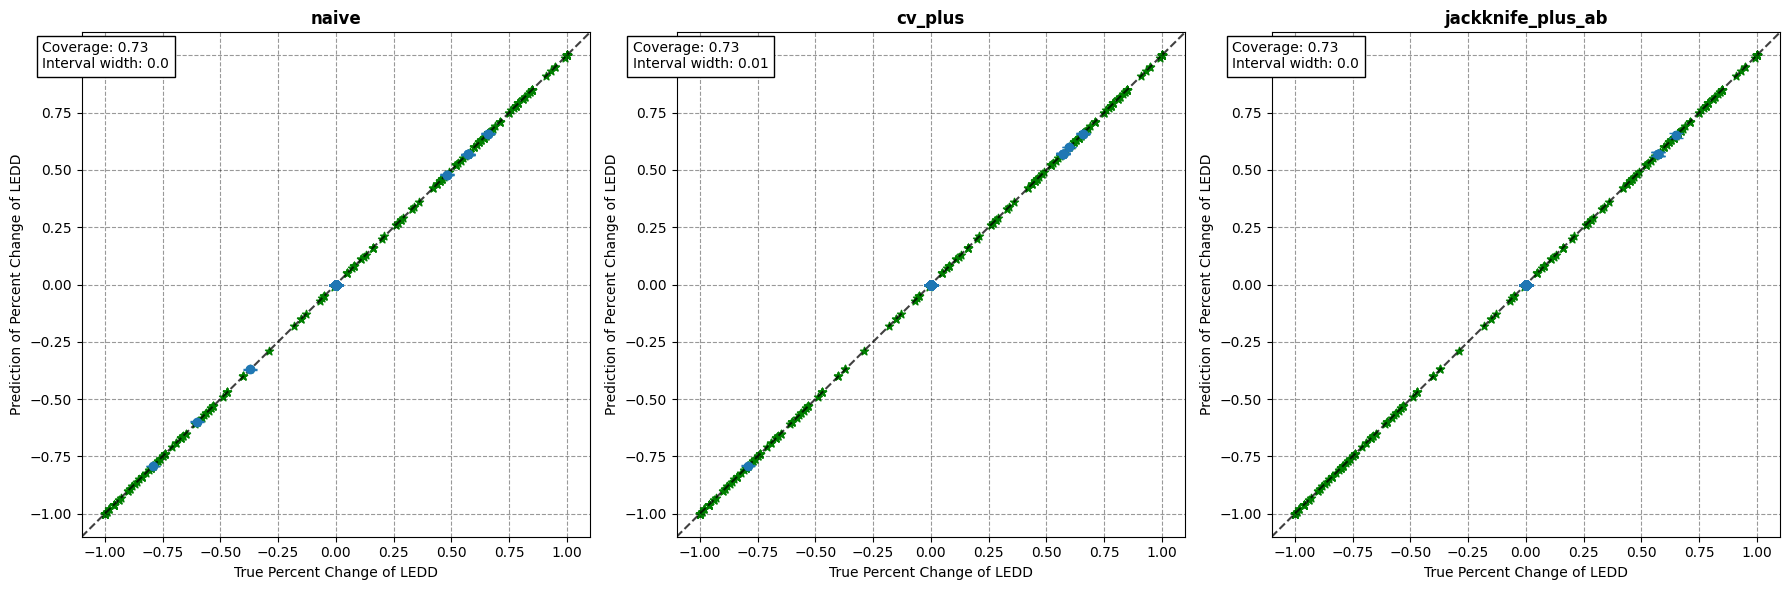

In [115]:
def conformal_prediction_zero_inflated_mapie(X, y_binary, y_continuous, alpha_tilda=0.9):
    """
    Two-stage conformal prediction with multiple MAPIE strategies
    """
    # Split data into five parts
    (X_train, X_calib1, X_calib2, X_calib3, X_test,
     y_binary_train, y_binary_calib1, y_binary_calib2, y_binary_calib3, y_binary_test,
     y_cont_train, y_cont_calib1, y_cont_calib2, y_cont_calib3, y_cont_test) = split_into_five_equal_parts(
        X, y_binary, y_continuous
    )
    
    # Define MAPIE strategies like in your original code
    STRATEGIES = {
        "naive": {"method": "naive"},
        "cv_plus": {"method": "plus", "cv": 10},
        "jackknife_plus_ab": {"method": "plus", "cv": Subsample(n_resamplings=50)},
    }
    
    # Initialize dictionaries to store results
    y_pred, y_pis = {}, {}
    y_test_sorted, y_pred_sorted, lower_bound, upper_bound = {}, {}, {}, {}
    coverage, width = {}, {}
    
    # First stage: Classification model (common for all strategies)
    classifier = xgb.XGBClassifier(**binary_params)
    classifier.fit(X_train, y_binary_train)
    
    # Get probabilities for calibration set 1
    probs_calib1 = classifier.predict_proba(X_calib1)[:, 1]
    
    # For each MAPIE strategy
    for strategy, params in STRATEGIES.items():
        # Initialize regressor
        regressor = xgb.XGBRegressor(**regression_params_short)
        
        # Initialize MAPIE with current strategy
        mapie = MapieRegressor(
            estimator=regressor,
            random_state=42,
            **params
        )
        
        # Try different r values
        r_values = np.arange(0.1, 0.95, 0.05)
        all_interval_lengths = []
        
        for r in r_values:
            # First calibration: threshold for zero/non-zero
            alpha_r = np.quantile(probs_calib1, r)
            
            # Second calibration: accuracy of zero predictions
            probs_calib2 = classifier.predict_proba(X_calib2)[:, 1]
            pred_zeros = probs_calib2 <= alpha_r
            beta_hat = np.mean(y_binary_calib2[pred_zeros] == 0)
            
            # Calculate final quantile and ensure it's in [0,1]
            final_quantile = (alpha_tilda - beta_hat * r) / (1 - r)
            final_quantile = np.clip(final_quantile, 0.01, 0.99)
            
            # Third calibration: Use MAPIE for interval width
            probs_calib3 = classifier.predict_proba(X_calib3)[:, 1]
            nonzero_mask = probs_calib3 > alpha_r
            
            if not any(nonzero_mask):
                continue
            
            try:
                # Fit MAPIE on non-zero data
                X_calib3_nonzero = X_calib3[nonzero_mask]
                y_calib3_nonzero = y_cont_calib3[nonzero_mask]
                
                mapie.fit(X_calib3_nonzero, y_calib3_nonzero)
                _, y_pis_calib = mapie.predict(X_calib3_nonzero, alpha=final_quantile)
                
                # Calculate interval width
                interval_width = np.mean(y_pis_calib[:, 1, 0] - y_pis_calib[:, 0, 0])
                all_interval_lengths.append((r, interval_width, alpha_r, mapie))
                
            except Exception as e:
                print(f"Skipping {strategy} with r={r} due to error: {e}")
                continue
        
        if not all_interval_lengths:
            print(f"No valid intervals found for strategy {strategy}")
            continue
        
        # Choose best r value and corresponding MAPIE model
        best_r, best_width, best_alpha_r, best_mapie = min(all_interval_lengths, key=lambda x: x[1])
        
        # Final predictions on test set
        test_probs = classifier.predict_proba(X_test)[:, 1]
        nonzero_mask_test = test_probs > best_alpha_r
        
        # Initialize bounds
        lower_bound[strategy] = np.zeros(len(X_test))
        upper_bound[strategy] = np.zeros(len(X_test))
        
        if any(nonzero_mask_test):
            _, y_pis_test = best_mapie.predict(X_test[nonzero_mask_test], alpha=alpha_tilda)
            lower_bound[strategy][nonzero_mask_test] = y_pis_test[:, 0, 0]
            upper_bound[strategy][nonzero_mask_test] = y_pis_test[:, 1, 0]
        
        # Calculate coverage and width using MAPIE metrics
        coverage[strategy] = regression_coverage_score(
            y_cont_test,
            lower_bound[strategy],
            upper_bound[strategy]
        )
        width[strategy] = regression_mean_width_score(
            lower_bound[strategy],
            upper_bound[strategy]
        )
    
    return lower_bound, upper_bound, y_cont_test, coverage, width

# Run the analysis
results = conformal_prediction_zero_inflated_mapie(
    X=X,
    y_binary=y_pred_all,
    y_continuous=normalized_pctg_change,
    alpha_tilda=0.9
)

lower_bound, upper_bound, y_test, coverage, width = results

# Print results for each strategy
for strategy in coverage.keys():
    print(f"\nStrategy: {strategy}")
    print(f"Coverage: {coverage[strategy]:.3f}")
    print(f"Average interval width: {width[strategy]:.3f}")

# Visualization similar to your original code
rng = np.random.default_rng(21)
perc_obs_plot = 0.90
num_plots = rng.choice(len(y_test), int(perc_obs_plot*len(y_test)), replace=False)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
coords = axs.ravel()

for strategy, coord in zip(lower_bound.keys(), coords):
    plot_prediction_intervals(
        strategy, coord, y_test, (lower_bound[strategy] + upper_bound[strategy])/2,
        lower_bound[strategy], upper_bound[strategy],
        coverage[strategy], width[strategy],
        num_plots
    )
    coord.grid(True, linestyle='--', alpha=0.4, linewidth=0.8, color='black')

plt.tight_layout()
plt.show()

Coverage: 0.892
Average interval width: 0.755


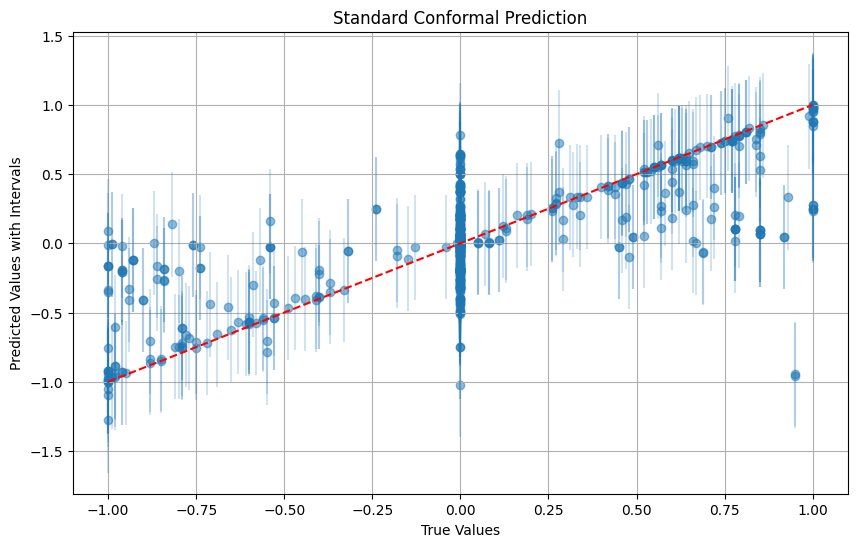

In [224]:
def standard_conformal_prediction(X_train, y_train, X_calib, y_calib, X_test, alpha=0.9):
    """
    Basic conformal prediction implementation.
    
    Parameters:
    -----------
    X_train : Training features
    y_train : Training target
    X_calib : Calibration features
    y_calib : Calibration target
    X_test : Test features
    alpha : Target coverage level (default 0.9 for 90% coverage)
    
    Returns:
    --------
    lower_bound, upper_bound : Prediction intervals for test set
    """
    # 1. Train the model on training data
    model = xgb.XGBRegressor(**regression_params_short)
    model.fit(X_train, y_train)
    
    # 2. Calculate nonconformity scores on calibration set
    calib_preds = model.predict(X_calib)
    nonconformity_scores = np.abs(y_calib - calib_preds)
    
    # 3. Find the quantile corresponding to desired coverage
    quantile = np.quantile(nonconformity_scores, alpha)
    
    # 4. Make predictions on test set
    test_preds = model.predict(X_test)
    
    # 5. Create prediction intervals
    lower_bound = test_preds - quantile
    upper_bound = test_preds + quantile
    
    return lower_bound, upper_bound

# Usage example:
# First split data into train, calibration, and test
X_train, X_temp, y_train, y_temp = train_test_split(X, normalized_pctg_change, test_size=0.4, random_state=42)
X_calib, X_test, y_calib, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Get prediction intervals
lower, upper = standard_conformal_prediction(
    X_train, y_train,
    X_calib, y_calib,
    X_test,
    alpha=0.9
)

# Calculate coverage
coverage = np.mean((y_test >= lower) & (y_test <= upper))
interval_width = np.mean(upper - lower)

print(f"Coverage: {coverage:.3f}")
print(f"Average interval width: {interval_width:.3f}")

# Visualize results
plt.figure(figsize=(10, 6))
plt.scatter(y_test, (upper + lower)/2, alpha=0.5)
plt.errorbar(y_test, (upper + lower)/2, 
            yerr=(upper - lower)/2, 
            fmt='none', alpha=0.2)
plt.plot([y_test.min(), y_test.max()], 
         [y_test.min(), y_test.max()], 
         '--', color='red')
plt.xlabel('True Values')
plt.ylabel('Predicted Values with Intervals')
plt.title('Standard Conformal Prediction')
plt.grid(True)
plt.show()